In [ ]:
!nvidia-smi
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
import torch
import torch.nn as nn
import numpy as np
import os
import torchvision
print(torch.__version__)
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
print(torch.cuda.is_available())

Fri Feb  4 10:53:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    38W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

fmnist_train = datasets.FashionMNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
fmnist_test = datasets.FashionMNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

train_loader = DataLoader(dataset=fmnist_train, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(dataset=fmnist_test, batch_size=100, shuffle=False, num_workers=4)

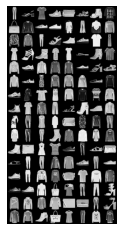

In [ ]:
import matplotlib.pyplot as plt
def imshow(img):
    # img = img / 2 + 0.5     # denormalize
    npimg = img.numpy()
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader) # iterator
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

In [ ]:
class VGG(nn.Module):
    def __init__(self, features, num_classes=1000, init_weights=True):  #features 부분은 vgg모델간 호환성
        super(VGG, self).__init__()
        self.features=features
        self.avgpool= nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(1024, 2048),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(2048, num_classes),
    )
        if init_weights:
            self._initialize_weights()
    def forward(self, x):        # forward prop 을 진행시키는 함수
        x= self.features(x)
        x= self.avgpool(x)
        x= x.view(x.size(0), -1)
        x= self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu') #initialization의 한 종류
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.BatchNorm2d):
                    nn.init.constant_(m.weight, 1)  #텐서를 (0,1) 로 초기화
                    nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.Linear):
                    nn.init.normal_(m.weight, 0, 0.01)
                    nn.init.constant_(m.bias, 0)

In [ ]:
def make_layers(cfg, batch_norm=False):  # cfg의 입력값에 따라 layers가 차례로 쌓임
    layers = []                          # 숫자가 들어올 경우 conv2d수행,  M이 들어올 경우 max pooling 수행
    in_channels = 1
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        elif v == 'M_3':
            layers += [nn.MaxPool2d(kernel_size=3, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels =v
    return nn.Sequential(*layers)

In [ ]:
cfg = {
    # 8 + 3 = 11 -> vgg11
    'A': [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    # 10 + 3 = 11 -> vgg13
    'B': [64, 64, "M", 128, 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    # 13 + 3 = 11 -> vgg16
    'D': [64, 64, "M", 128, 128, "M", 256, 256, 256, "M_3", 512, 512, 512],
    # 16 + 3 = 11 -> vgg19
    'E': [64, 64, "M", 128, 128, "M", 256, 256, 256, 256, "M", 512, 512, 512, 512, "M", 512, 512, 512, 512, "M"],
}

In [ ]:
feature = make_layers(cfg['D'], batch_norm=True)

In [ ]:
CNN= VGG(feature, num_classes=10, init_weights=True).to("cuda")

In [ ]:
CNN

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
optimizer = torch.optim.SGD(CNN.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
decay_epoch = [32000, 48000]
criterion = torch.nn.CrossEntropyLoss()
step_lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=decay_epoch, gamma=0.1)

In [ ]:
#93.67
import time
start_time = time.time()

CNN.train()

step = 0
epochs = 0
losses = []

while step < 64000:

    train_loss = 0.0
    correct = 0.0
    total = 0.0

    for batch_idx, (x, y) in enumerate(train_loader):
        step += 1
        step_lr_scheduler.step()
        x, y = x.to("cuda"), y.to("cuda")
        out = CNN(x)
        loss = criterion(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        correct += (out.argmax(1) == y).float().sum().item()
        total += x.size(0)
        train_loss += loss.item()

    losses.append(train_loss)
    epochs += 1
    
    print("Epoch[{:d}] ({:d}/64000) ({:.4f}sec)] loss: {:.2f} acc: {:.2f}".format(epochs, step, time.time()-start_time, train_loss, 100.*correct/total))
    

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch[1] (469/64000) (13.1525sec)] loss: 320.13 acc: 75.34
Epoch[2] (938/64000) (25.5781sec)] loss: 134.77 acc: 89.91
Epoch[3] (1407/64000) (37.9904sec)] loss: 107.97 acc: 91.94
Epoch[4] (1876/64000) (50.4067sec)] loss: 89.97 acc: 93.33
Epoch[5] (2345/64000) (63.0903sec)] loss: 76.62 acc: 94.31
Epoch[6] (2814/64000) (75.4696sec)] loss: 65.75 acc: 94.95
Epoch[7] (3283/64000) (87.8596sec)] loss: 55.53 acc: 95.92
Epoch[8] (3752/64000) (100.2729sec)] loss: 49.78 acc: 96.33
Epoch[9] (4221/64000) (112.6972sec)] loss: 41.61 acc: 96.85
Epoch[10] (4690/64000) (125.0810sec)] loss: 36.43 acc: 97.25
Epoch[11] (5159/64000) (137.4698sec)] loss: 33.41 acc: 97.53
Epoch[12] (5628/64000) (149.8521sec)] loss: 26.61 acc: 98.05
Epoch[13] (6097/64000) (162.2535sec)] loss: 24.74 acc: 98.19
Epoch[14] (6566/64000) (174.6508sec)] loss: 21.70 acc: 98.40
Epoch[15] (7035/64000) (187.0438sec)] loss: 17.48 acc: 98.70
Epoch[16] (7504/64000) (199.4357sec)] loss: 17.33 acc: 98.73
Epoch[17] (7973/64000) (211.8354sec)] l

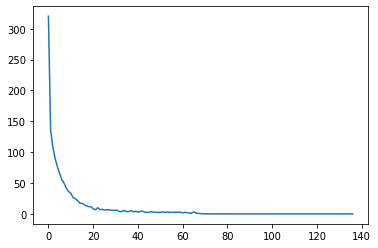

In [ ]:
plt.plot(losses)

In [ ]:
CNN.eval()
test_correct = 0.0
test_total = 0.0
for batch_idx, (x, y) in enumerate(test_loader):
    x, y = x.to("cuda"), y.to("cuda")
    out = CNN(x)
    test_correct += (out.argmax(1) == y).float().sum().item()
    test_total += x.size(0)
    
print(test_correct/test_total * 100.)

93.41000000000001


In [ ]:
import torch.nn.functional as F

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, down_sample=False):
        super(ResidualBlock, self).__init__()
        self.conv1=nn.Conv2d(in_channels, out_channels, kernel_size=3,
                             stride=stride, padding=1, bias=False)
        self.bn1 =nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.down_sample = down_sample
        self.stride = stride
        self.in_channels = in_channels
        self.out_channels = out_channels

    def down_sampling(self, x):
        out = F.pad(x, (0, 0, 0, 0, 0, self.out_channels - self.in_channels))
        out = nn.MaxPool2d(2, stride= self.stride)(out)
        return out
    
    def forward(self, x):
        shortcut = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.down_sample:
            shortcut = self.down_sampling(x)
        out+= shortcut
        out = self.relu(out)
        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self, num_layers, block, num_classes=10):
        super(ResNet,self).__init__()
        self.num_layers = num_layers

        self.conv1 = nn.Conv2d(  in_channels=1,  out_channels=16,  kernel_size=3, stride=1, padding=1, bias= False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)

        self.layers_2n = self.get_layers(block, 16 ,16, stride = 1)

        self.layers_4n = self.get_layers(block, 16, 32, stride = 2)

        self.layers_6n = self.get_layers(block, 32, 64, stride = 2)

        self.avg_pool = nn.AvgPool2d(7, stride = 1)
        self.fc_out = nn.Linear(64, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        
    def get_layers(self, block, in_channels, out_channels, stride):
        if stride ==2:
            down_sample = True
        else:
            down_sample =False
        layer_list = nn.ModuleList([block(in_channels, out_channels, stride, down_sample)])
        for _ in range(self.num_layers -1):
            layer_list.append(block(out_channels, out_channels))
        return nn.Sequential(*layer_list)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x= self.layers_2n(x)
        x= self.layers_4n(x)
        x= self.layers_6n(x)

        x= self.avg_pool(x)
        x= x.view(x.size(0), -1)
        x= self.fc_out(x)
        return x

In [ ]:
def resnet18():
    block = ResidualBlock
    model = ResNet(3, block)
    return model

In [ ]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, down_sample=False):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride= stride, padding=1 ,bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace = True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.stride = stride
        self.in_channels = in_channels
        self.out_channels =out_channels

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        return out

In [ ]:
def cnn18():
    block = Block
    model = ResNet(3, block)
    return model
def cnn32():
    block = Block
    model = ResNet(5, block)
    return model

In [ ]:
net = resnet18().to("cuda")
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
decay_epoch=[32000, 48000]
step_lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=decay_epoch, gamma = 0.1)

In [ ]:
start_time = time.time()
net.train()
step=0
epochs=0
losses =[]
while step < 64000:
    train_loss=0.0
    correct=0.0
    total=0.0
    for batch_idx, (x,y) in enumerate(train_loader):
        step+=1
        step_lr_scheduler.step()
        x, y= x.to("cuda"), y.to("cuda")
        out = net(x)
        loss = criterion(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        correct += (out.argmax(1) == y).float().sum().item()
        total +=x.size(0)
        train_loss += loss.item()
    losses.append(train_loss)
    epochs+=1
    print("Epoch[{:d} ({:d}/64000) ({:.4f}sec)] loss: {:.2f} acc: {:.2f}".format(epochs, step, time.time()- start_time, train_loss, 100.*correct/total))

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch[1 (469/64000) (11.4456sec)] loss: 263.49 acc: 79.66
Epoch[2 (938/64000) (22.7941sec)] loss: 132.93 acc: 89.78
Epoch[3 (1407/64000) (34.2319sec)] loss: 110.05 acc: 91.29
Epoch[4 (1876/64000) (45.6910sec)] loss: 98.57 acc: 92.24
Epoch[5 (2345/64000) (57.3408sec)] loss: 88.35 acc: 93.16
Epoch[6 (2814/64000) (68.8130sec)] loss: 81.11 acc: 93.69
Epoch[7 (3283/64000) (80.7299sec)] loss: 75.75 acc: 94.12
Epoch[8 (3752/64000) (92.2018sec)] loss: 71.87 acc: 94.34
Epoch[9 (4221/64000) (103.7910sec)] loss: 64.73 acc: 94.87
Epoch[10 (4690/64000) (114.9982sec)] loss: 61.53 acc: 95.16
Epoch[11 (5159/64000) (126.4644sec)] loss: 58.61 acc: 95.37
Epoch[12 (5628/64000) (138.1207sec)] loss: 56.29 acc: 95.58
Epoch[13 (6097/64000) (149.7424sec)] loss: 52.90 acc: 95.91
Epoch[14 (6566/64000) (161.5738sec)] loss: 49.09 acc: 96.18
Epoch[15 (7035/64000) (173.0423sec)] loss: 46.39 acc: 96.33
Epoch[16 (7504/64000) (184.7727sec)] loss: 42.69 acc: 96.67
Epoch[17 (7973/64000) (196.4793sec)] loss: 41.09 acc: 96

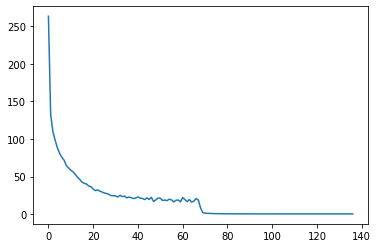

In [ ]:
plt.plot(losses)

In [ ]:
net.eval()
test_correct =0.0
test_total=0.0
for batch_idx, (x,y) in enumerate(test_loader):
     x, y =x.to("cuda"), y.to('cuda')
     out = net(x)
     test_correct +=(out.argmax(1) == y).float().sum().item()
     test_total += x.size(0)
     
print(test_correct/test_total *100)

93.73
